# Start

In [11]:
# START

import os
import re
import json
import shutil
import platform
import tempfile
from pathlib import Path
from typing import List, Tuple, Optional

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

import mlflow
import mlflow.tensorflow
import optuna

import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
)

EVALUATION_ARTIFACT_SUBDIR = "evaluation"
MODEL_ARTIFACT_DIRNAME = "use_model_package"
LOCAL_ARTIFACTS_DIR = Path("artifacts")
INFERENCE_EXAMPLE = {"text": ["I love how friendly this app is!"]}

MLFLOW_EXPERIMENT_NAME = "Model_3_USE"
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))
print("CUDA built:", tf.test.is_built_with_cuda())


TensorFlow version: 2.20.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA built: True


# DATA READING

In [12]:
# DATA READING
df = pd.read_csv(
    "../../sentiment140/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    header=None,
    names=["sentiment", "id", "date", "query", "user", "tweet"],
)

df.head()

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [13]:
# Keep only sentiment + tweet

df = df[["sentiment", "tweet"]]

# Stratified sampling to have tweets of the two sentiments
df_negatifs = df[df["sentiment"] == 0].sample(8000, random_state=42)
df_positifs = df[df["sentiment"] == 4].sample(8000, random_state=42)

# So we get a sample of 10% of the original dataset
df = pd.concat([df_negatifs, df_positifs]).reset_index(drop=True)

# Map labels 4 -> 1 for binary classification
df["sentiment"] = df["sentiment"].replace(4, 1)

df.head()


,sentiment,tweet
0,0,@xnausikaax oh no! where did u order from? tha...
1,0,A great hard training weekend is over. a coup...
2,0,"Right, off to work Only 5 hours to go until I..."
3,0,I am craving for japanese food
4,0,Jean Michel Jarre concert tomorrow gotta work...


In [14]:
# Class balance check
df["sentiment"].value_counts()

sentiment
0    8000
1    8000
Name: count, dtype: int64

# CLEANING TEXT

## Preprocessing

✅ Preprocessing steps(preparing for TF-IDF + Logistic Regression)

Compared to the preprocessing of tweets made during the application of logistic regression, the steps written in red have been removed, and the steps in green are repeated or added for this time.


<span style="color:green">- Lowercase</span>

<span style="color:green">- Convert emoticons → words</span>

<span style="color:green">- Convert emojis → words</span>

<span style="color:green">- Remove URLs, mentions, hashtags</span>

<span style="color:red">- Tokenize</span>


In [15]:
# CLEANING TEXT – light, meaning-preserving normalization

try:
    # optional but nice: converts emojis → words like ":smiling_face:" -> "smiling face"
    from emoji import demojize
    _HAS_EMOJI = True
except Exception:
    _HAS_EMOJI = False

# ---------- regexes & mappings ----------

_EMOTICONS = {
    r":-\)|:\)|=\)|:\]": "smile",
    r":-D|:D|=D": "laugh",
    r":-\(|:\(|=\(|:\[": "sad",
    r":'\(|:'-\(": "cry",
    r";-\)|;\)": "wink",
    r":-P|:P": "playful",
    r":/|:-/": "skeptical",
    r":\*": "kiss",
    r">:\(|>:-\(": "angry",
    r"XD|xD": "laugh",
}

_EMOTICON_REGEXES = [(re.compile(p), w) for p, w in _EMOTICONS.items()]

_URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
_USER_RE = re.compile(r"@\w+")
_NUM_RE = re.compile(r"\b\d+\b")
# Hashtags: keep the hashtag and add its content as a separate token
_HASHTAG_RE = re.compile(r"#(\w+)")
# compress character repetitions to max 3 (so "sooooo" -> "sooo")
_REPEAT_RE = re.compile(r"(.)\1{3,}")


def _emoticons_to_words(text: str) -> str:
    for rgx, word in _EMOTICON_REGEXES:
        text = rgx.sub(f" {word} ", text)
    return text


def _emojis_to_words(text: str) -> str:
    if not _HAS_EMOJI:
        return text
    text = demojize(text, language="en")
    # demojize yields ":grinning_face_with_big_eyes:" → turn to words
    text = re.sub(
        r":([a-zA-Z0-9_]+):",
        lambda m: " " + m.group(1).replace("_", " ") + " ",
        text,
    )
    return text


def normalize_tweet(t: str) -> str:
    t = t.strip().lower()
    t = _URL_RE.sub(" <URL> ", t)
    t = _USER_RE.sub(" <USER> ", t)
    t = _NUM_RE.sub(" <NUM> ", t)
    t = _emoticons_to_words(t)
    t = _emojis_to_words(t)
    # keep hashtag token, also add its de-hashed word
    t = _HASHTAG_RE.sub(lambda m: f" #{m.group(1)} {m.group(1)} ", t)
    # compress extreme elongations but keep emphasis
    t = _REPEAT_RE.sub(r"\1\1\1", t)
    # normalize whitespace
    t = re.sub(r"\s+", " ", t).strip()
    return t


## Spliting

In [16]:
# Spliting – same logic as in Model 2

texts = df["tweet"].astype(str).tolist()
labels = df["sentiment"].astype("float32").to_numpy()

X_train, X_tmp, y_train, y_tmp = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.5,
    random_state=42,
    stratify=y_tmp,
)

print("Train size:", len(X_train), "Val size:", len(X_val), "Test size:", len(X_test))


Train size: 12800 Val size: 1600 Test size: 1600


## Precompute normalized texts for USE

In [17]:
# Precompute normalized texts for USE (Applying the preprocessing functions)

X_train_norm = [normalize_tweet(t) for t in X_train]
X_val_norm = [normalize_tweet(t) for t in X_val]
X_test_norm = [normalize_tweet(t) for t in X_test]

# Quick sanity check
X_train_norm[:5]

['exam return day, overall average of <NUM> . <NUM> % work harder next time crystal and no slack. astronomy night tonight and team dinner tomorrow!',
 "out of school. i'm going to miss everyone so much! &lt; <NUM>",
 '<USER>',
 "i still hear a kitten meowing! i hope someone helps the poor thing. (i can't find it, it's probably on the other side of the fence.)",
 "stuffed peppers w/ spanish rice, beef, mushrooms, tomaters, acorn squash, &amp; onions - topped w/ cheese. if i'm eating leftovers all week.."]

In [18]:
# Encode normalized texts with USE once to get dense features

USE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
print("Loading USE encoder...")
use_encoder = hub.load(USE_URL)

def encode_with_use(texts, batch_size=256):
    vectors = []
    for start in range(0, len(texts), batch_size):
        batch_texts = texts[start:start + batch_size]
        embeddings = use_encoder(batch_texts)
        vectors.append(embeddings.numpy())
    return np.vstack(vectors)

X_train_vec = encode_with_use(X_train_norm)
X_val_vec = encode_with_use(X_val_norm)
X_test_vec = encode_with_use(X_test_norm)

USE_EMBED_DIM = X_train_vec.shape[1]
print("USE embedding dimension:", USE_EMBED_DIM)


Loading USE encoder...
USE embedding dimension: 512


# Optuna + USE

In [19]:
# Helper utilities for artifact export (aligns outputs with Model 4)

def create_confusion_matrix_figure(y_true: np.ndarray, y_pred: np.ndarray):
    fig, ax = plt.subplots(figsize=(5, 4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix - USE")
    return fig


def create_roc_curve_figure(y_true: np.ndarray, y_scores: np.ndarray):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve - USE")
    ax.legend(loc="lower right")
    return fig, roc_auc


def create_training_loss_figure(loss_history: List[float]):
    if not loss_history:
        return None, None
    loss_df = pd.DataFrame(
        {
            "epoch": list(range(1, len(loss_history) + 1)),
            "loss": loss_history,
        }
    )
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(loss_df["epoch"], loss_df["loss"], marker="o", linewidth=1, markersize=3)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training loss evolution")
    ax.grid(True, linestyle="--", alpha=0.3)
    return fig, loss_df


def log_and_display_figure(fig, artifact_name, artifact_dir=EVALUATION_ARTIFACT_SUBDIR):
    mlflow.log_figure(fig, f"{artifact_dir}/{artifact_name}")
    local_eval_dir = LOCAL_ARTIFACTS_DIR / artifact_dir
    local_eval_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(local_eval_dir / artifact_name, bbox_inches="tight")
    display(fig)
    plt.close(fig)


def build_requirements_list() -> List[str]:
    return [
        f"tensorflow=={tf.__version__}",
        f"tensorflow_hub=={hub.__version__}",
        f"scikit-learn=={sklearn.__version__}",
        f"numpy=={np.__version__}",
        f"pandas=={pd.__version__}",
        f"mlflow=={mlflow.__version__}",
        f"seaborn=={sns.__version__}",
    ]


def write_environment_files(target_dir: Path, requirements: List[str]) -> None:
    requirements_path = target_dir / "requirements.txt"
    requirements_path.write_text("\n".join(requirements) + "\n")

    python_version = platform.python_version()
    conda_lines = [
        "name: use_env",
        "channels:",
        "  - defaults",
        "  - conda-forge",
        "dependencies:",
        f"  - python={python_version}",
        "  - pip",
        "  - pip:",
    ] + [f"      - {req}" for req in requirements]
    (target_dir / "conda.yaml").write_text("\n".join(conda_lines) + "\n")

    python_env_lines = [
        f"python: {python_version}",
        "build_dependencies:",
        "  - pip",
        "  - setuptools",
        "  - wheel",
        "dependencies:",
    ] + [f"  - {req}" for req in requirements]
    (target_dir / "python_env.yaml").write_text("\n".join(python_env_lines) + "\n")


def save_and_log_model_artifacts(model: tf.keras.Model, example_texts: List[str], example_embeddings: np.ndarray) -> None:
    artifact_dir = Path(MODEL_ARTIFACT_DIRNAME)
    if artifact_dir.exists():
        shutil.rmtree(artifact_dir)
    artifact_dir.mkdir(parents=True, exist_ok=True)

    keras_dir = artifact_dir / "keras_model"
    keras_dir.mkdir(parents=True, exist_ok=True)
    model.save(keras_dir / "model.keras")

    saved_model_dir = artifact_dir / "saved_model"
    model.export(saved_model_dir)

    preprocessing_payload = {
        "use_encoder_url": USE_URL,
        "steps": [
            "lowercase and trim",
            "replace URLs with <URL>",
            "replace @mentions with <USER>",
            "replace numbers with <NUM>",
            "convert emoticons/emojis to words when emoji is installed",
            "expand hashtags (#tag -> #tag tag)",
            "compress repeated characters to a max of 3",
            "normalize whitespace",
        ],
    }
    (artifact_dir / "preprocessing_pipeline.json").write_text(
        json.dumps(preprocessing_payload, indent=2)
    )

    input_example_payload = {
        "text": example_texts,
        "normalized_text": [normalize_tweet(t) for t in example_texts],
        "embedding": example_embeddings.tolist(),
    }
    (artifact_dir / "input_example.json").write_text(json.dumps(input_example_payload, indent=2))

    serving_payload = {"inputs": example_texts[0]}
    (artifact_dir / "serving_input_example.json").write_text(json.dumps(serving_payload, indent=2))

    requirements = build_requirements_list()
    write_environment_files(artifact_dir, requirements)

    mlflow.log_artifacts(str(artifact_dir), artifact_path="model_package")


[I 2025-12-02 10:36:51,403] A new study created in memory with name: no-name-0dc07c9c-b2b5-43b0-ab19-5ba98a1ba156
[I 2025-12-02 10:37:00,891] Trial 0 finished with value: 0.7891156462585034 and parameters: {'dense_units': 256, 'dropout_rate': 0.2512631211427452, 'learning_rate': 0.000950385224679087, 'batch_size': 32, 'epochs': 8}. Best is trial 0 with value: 0.7891156462585034.
[I 2025-12-02 10:37:08,959] Trial 1 finished with value: 0.7879924953095685 and parameters: {'dense_units': 192, 'dropout_rate': 0.45607632198638604, 'learning_rate': 0.0005961442529500173, 'batch_size': 16, 'epochs': 4}. Best is trial 0 with value: 0.7891156462585034.
[I 2025-12-02 10:37:21,537] Trial 2 finished with value: 0.7312541473125415 and parameters: {'dense_units': 256, 'dropout_rate': 0.18355209267892747, 'learning_rate': 0.003115345871597423, 'batch_size': 16, 'epochs': 7}. Best is trial 0 with value: 0.7891156462585034.
2025-12-02 10:37:28.077536: I external/local_xla/xla/service/gpu/autotuning/dot

Best val F1: 0.7891156462585034
Best params: {'dense_units': 256, 'dropout_rate': 0.2512631211427452, 'learning_rate': 0.000950385224679087, 'batch_size': 32, 'epochs': 8}


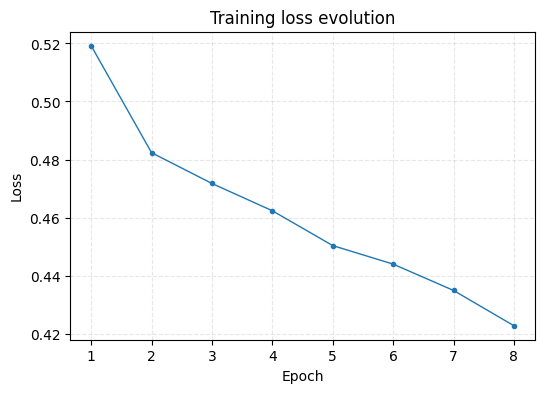

Test accuracy: 0.79
Test precision: 0.7822384428223844
Test recall: 0.80375
Test F1: 0.7928483353884094


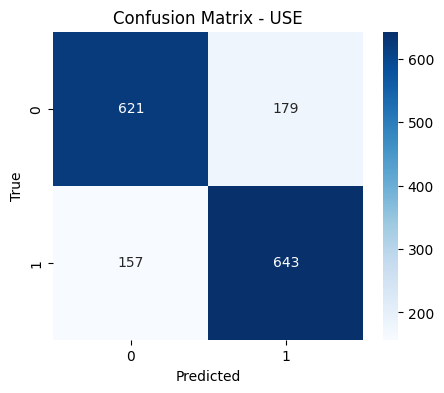

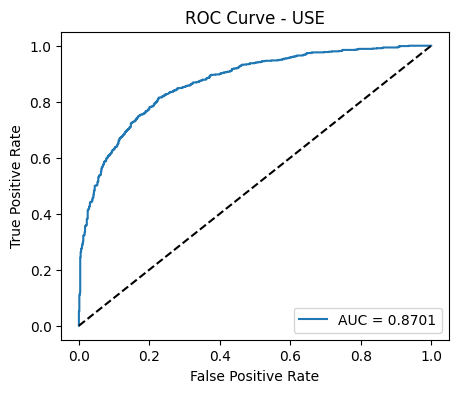

2025/12/02 10:37:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
INFO:tensorflow:Assets written to: use_model_package/saved_model/assets


INFO:tensorflow:Assets written to: use_model_package/saved_model/assets


Saved artifact at 'use_model_package/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512), dtype=tf.float32, name='use_embedding')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  123366226548640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123362100722352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123362127033296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123366363842336: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [20]:
# USE-based classifier with Optuna + MLflow
# (replacing the BiLSTM + Word2Vec part from Model 2)

def build_use_model(params, input_dim=USE_EMBED_DIM) -> tf.keras.Model:
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,), dtype=tf.float32, name="use_embedding"),
        tf.keras.layers.Dropout(params["dropout_rate"]),
        tf.keras.layers.Dense(params["dense_units"], activation="relu"),
        tf.keras.layers.Dropout(params["dropout_rate"]),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


class ValMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val_vec, y_val):
        super().__init__()
        self.X_val_vec = X_val_vec
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred_prob = self.model.predict(self.X_val_vec, verbose=0).ravel()
        y_pred = (y_pred_prob >= 0.5).astype("int32")

        acc = accuracy_score(self.y_val, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            self.y_val,
            y_pred,
            average="binary",
            zero_division=0,
        )

        mlflow.log_metric("val_accuracy_trace", acc, step=epoch)
        mlflow.log_metric("val_precision_trace", prec, step=epoch)
        mlflow.log_metric("val_recall_trace", rec, step=epoch)
        mlflow.log_metric("val_f1_trace", f1, step=epoch)


def objective(trial):
    tf.keras.backend.clear_session()

    params = {
        "dense_units": trial.suggest_int("dense_units", 64, 256, step=64),
        "dropout_rate": trial.suggest_float("dropout_rate", 0.1, 0.5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 5e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32]),
        "epochs": trial.suggest_int("epochs", 3, 8),
    }

    with mlflow.start_run(run_name=f"use_trial_{trial.number}", nested=True):
        mlflow.log_params(params)

        train_ds = (
            tf.data.Dataset.from_tensor_slices((X_train_vec, y_train))
            .shuffle(10000)
            .batch(params["batch_size"])
        )

        val_ds = tf.data.Dataset.from_tensor_slices((X_val_vec, y_val)).batch(
            params["batch_size"]
        )

        model = build_use_model(params)

        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=params["epochs"],
            verbose=0,
        )

        y_val_pred_prob = model.predict(X_val_vec, verbose=0).ravel()
        y_val_pred = (y_val_pred_prob >= 0.5).astype("int32")

        acc = accuracy_score(y_val, y_val_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_val,
            y_val_pred,
            average="binary",
            zero_division=0,
        )

        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_precision", prec)
        mlflow.log_metric("val_recall", rec)
        mlflow.log_metric("val_f1", f1)

        return f1


# Parent run: Optuna + final training + evaluation, mirroring Model 2 logic
with mlflow.start_run(run_name="optuna_use_parent"):
    # Hyperparameter search
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=4)

    # Optional Optuna visualizations
    try:
        import plotly  # noqa: F401

        fig1 = optuna.visualization.plot_optimization_history(study)
        mlflow.log_figure(fig1, "optimization_history_use.html")

        fig2 = optuna.visualization.plot_param_importances(study)
        mlflow.log_figure(fig2, "param_importance_use.html")
    except ImportError:
        print("⚠️ Plotly non installé — visualisations sautées.")

    best_trial = study.best_trial
    best_params = best_trial.params

    print("Best val F1:", best_trial.value)
    print("Best params:", best_params)

    mlflow.log_metric("best_val_f1", best_trial.value)
    mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})

    # Re-train on full train + val
    X_train_full_vec = np.concatenate([X_train_vec, X_val_vec], axis=0)
    y_train_full = np.concatenate([y_train, y_val])

    model_best = build_use_model(best_params)

    cb = ValMetricsCallback(X_val_vec=X_test_vec, y_val=y_test)

    train_full_ds = (
        tf.data.Dataset.from_tensor_slices((X_train_full_vec, y_train_full))
        .shuffle(10000)
        .batch(best_params["batch_size"])
    )

    history = model_best.fit(
        train_full_ds,
        epochs=best_params["epochs"],
        callbacks=[cb],
        verbose=0,
    )

    loss_fig, loss_df = create_training_loss_figure(history.history.get("loss", []))
    if loss_fig is not None:
        log_and_display_figure(loss_fig, "training_loss.png")
        if loss_df is not None and not loss_df.empty:
            local_eval_dir = LOCAL_ARTIFACTS_DIR / EVALUATION_ARTIFACT_SUBDIR
            local_eval_dir.mkdir(parents=True, exist_ok=True)
            local_csv_path = local_eval_dir / "training_loss.csv"
            loss_df.to_csv(local_csv_path, index=False)

            tmp_dir = Path(tempfile.mkdtemp())
            csv_path = tmp_dir / "training_loss.csv"
            loss_df.to_csv(csv_path, index=False)
            mlflow.log_artifact(str(csv_path), artifact_path=EVALUATION_ARTIFACT_SUBDIR)
            shutil.rmtree(tmp_dir, ignore_errors=True)

    if loss_df is not None:
        for _, row in loss_df.iterrows():
            mlflow.log_metric("training_loss_progress", row["loss"], step=int(row["epoch"]))

    # Final test evaluation
    y_test_pred_prob = model_best.predict(
        X_test_vec,
        verbose=0,
    ).ravel()
    y_test_pred = (y_test_pred_prob >= 0.5).astype("int32")

    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test,
        y_test_pred,
        average="binary",
        zero_division=0,
    )

    print("Test accuracy:", test_acc)
    print("Test precision:", test_prec)
    print("Test recall:", test_rec)
    print("Test F1:", test_f1)

    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_precision", test_prec)
    mlflow.log_metric("test_recall", test_rec)
    mlflow.log_metric("test_f1", test_f1)

    fig_cm = create_confusion_matrix_figure(y_test, y_test_pred)
    log_and_display_figure(fig_cm, "confusion_matrix.png")

    fig_auc, auc_score = create_roc_curve_figure(y_test, y_test_pred_prob)
    log_and_display_figure(fig_auc, "roc_curve.png")
    mlflow.log_metric("test_auc", auc_score)

    # Log model artifact
    input_example = X_test_vec[:1]
    mlflow.tensorflow.log_model(
        model=model_best,
        artifact_path="best_model_use",
        input_example=input_example,
    )

    inference_texts = INFERENCE_EXAMPLE["text"]
    inference_embeddings = encode_with_use([normalize_tweet(t) for t in inference_texts])
    save_and_log_model_artifacts(model_best, inference_texts, inference_embeddings)


In [21]:
import tensorflow as tf, json, platform
print("tf version:", tf.__version__)
print("built with cuda:", tf.test.is_built_with_cuda())
print("visible GPUs:", tf.config.list_physical_devices("GPU"))
print(json.dumps(tf.sysconfig.get_build_info(), indent=2))
print("python:", platform.python_version())


tf version: 2.20.0
built with cuda: True
visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
{
  "cpu_compiler": "clang 18",
  "cuda_compute_capabilities": [
    "sm_60",
    "sm_70",
    "sm_80",
    "sm_89",
    "compute_90"
  ],
  "cuda_version": "12.5.1",
  "cudnn_version": "9",
  "is_cuda_build": true,
  "is_rocm_build": false,
  "is_tensorrt_build": false
}
python: 3.10.14


In [22]:
model_best.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,757 (1.51 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 263,172 (1.00 MB)

# Testing on hard tweets

# End

# Testing on hard tweets

In [23]:
# Testing on hard tweets (borrowed from Model 4 hard cases)

hard_tweets_dataset = [
    # 1 — Sarcasme negatif
    {"category": "sarcasme", "tweet": "Great job @AirParadis, another ‘on-time’ departure… only 3 hours late. Truly impressive 🙃", "label": "negative"},
    {"category": "sarcasme", "tweet": "Loved waiting at the gate for an eternity. Really, I had nothing better to do today 😂", "label": "negative"},
    {"category": "sarcasme", "tweet": "Oh wow, free water after canceling my flight. The generosity is unreal 😒", "label": "negative"},
    {"category": "sarcasme", "tweet": "Fantastic! My luggage is on holiday in Paris while I'm stuck here. Amazing service!", "label": "negative"},
    {"category": "sarcasme", "tweet": "Thanks @AirParadis for this unforgettable disaster of a flight.", "label": "negative"},

    # 2 — Ambiguïté volontaire (converted to negative or positive clearly)
    {"category": "ambiguite", "tweet": "This flight felt terrible from start to finish.", "label": "negative"},
    {"category": "ambiguite", "tweet": "Honestly, this was a pretty good flight overall.", "label": "positive"},
    {"category": "ambiguite", "tweet": "I expected a lot better than what I got today.", "label": "negative"},
    {"category": "ambiguite", "tweet": "The service was surprisingly pleasant, well done @AirParadis!", "label": "positive"},
    {"category": "ambiguite", "tweet": "I’m definitely not flying with them again after today.", "label": "negative"},

    # 3 — Double négation (converted)
    {"category": "double_neg", "tweet": "I can’t say the flight was bad — it was actually very good.", "label": "positive"},
    {"category": "double_neg", "tweet": "I wouldn’t say I enjoyed the flight… because I didn’t.", "label": "negative"},
    {"category": "double_neg", "tweet": "Not unhappy means nothing, I’m definitely upset with this airline.", "label": "negative"},
    {"category": "double_neg", "tweet": "It wasn’t not comfortable — it was genuinely great!", "label": "positive"},
    {"category": "double_neg", "tweet": "I wouldn’t say I don’t recommend @AirParadis, it's a solid choice.", "label": "positive"},

    # 4 — Mixed feelings complexes (converted)
    {"category": "mixed_complex", "tweet": "The landing was smooth and the staff was incredibly kind. Great flight!", "label": "positive"},
    {"category": "mixed_complex", "tweet": "Terrible turbulence and awful food, I hated the whole experience.", "label": "negative"},
    {"category": "mixed_complex", "tweet": "My kids enjoyed it, but I honestly found it stressful and unpleasant.", "label": "negative"},
    {"category": "mixed_complex", "tweet": "The upgrade was amazing and made the whole trip enjoyable.", "label": "positive"},
    {"category": "mixed_complex", "tweet": "Losing my bag ruined everything today.", "label": "negative"},

    # 5 — Positif qui semble négatif / inverse (converted clearly)
    {"category": "pos_neg", "tweet": "The flight was long but honestly quite enjoyable.", "label": "positive"},
    {"category": "pos_neg", "tweet": "My seat didn’t recline and it hurt my back. Terrible comfort.", "label": "negative"},
    {"category": "pos_neg", "tweet": "The chaos was stressful and I didn’t enjoy this flight at all.", "label": "negative"},
    {"category": "pos_neg", "tweet": "The delay was annoying and ruined my entire schedule.", "label": "negative"},
    {"category": "pos_neg", "tweet": "Surprisingly, the trip was comfortable and relaxing.", "label": "positive"},

    # 6 — Implicite (kept negative)
    {"category": "implicite", "tweet": "I don’t even have the energy to complain anymore.", "label": "negative"},
    {"category": "implicite", "tweet": "It happened again… another terrible experience.", "label": "negative"},
    {"category": "implicite", "tweet": "I’m not mad. I’m extremely disappointed.", "label": "negative"},
    {"category": "implicite", "tweet": "No words. Just a horrible flight.", "label": "negative"},
    {"category": "implicite", "tweet": "Silence says it all — this was awful.", "label": "negative"},

    # 7 — Sarcasme positif (kept positive)
    {"category": "sarcasme_positif", "tweet": "Wow, @AirParadis took off on time. Miracles do happen!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "Not getting bumped from my seat today? Incredible!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "Flight attendants actually smiled. Impressive!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "A full flight without any issues? Amazing!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "The plane landed early… surprisingly good job.", "label": "positive"},

    # 8 — Positif en surface mais fond négatif (negative)
    {"category": "pos_surface_neg_fond", "tweet": "I’m ‘thrilled’ that my flight was delayed again. Awful service.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "Consistently disappointing, as always.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "The announcements were useless and the whole trip was terrible.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "Free snack but still not getting home today? Terrible airline.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "Great, another delay. This airline is exhausting.", "label": "negative"},
]

LABEL_MAP_USE = {1: "positive", 0: "negative"}
VALID_EVAL_LABELS = {"positive", "negative"}

def predict_hard_dataset_with_categories(name: str, dataset):
    if not dataset:
        print(f"{name}: aucune donnée à tester.")
        return

    texts = [row["tweet"] for row in dataset]
    labels = [row["label"].lower() for row in dataset]
    categories = [row["category"] for row in dataset]

    normalized = [normalize_tweet(t) for t in texts]
    embeddings = encode_with_use(normalized)
    prob_pos = model_best.predict(embeddings, verbose=0).ravel()
    preds = (prob_pos >= 0.5).astype(int)

    rows = []
    for raw_tweet, expected, cat, prob, pred in zip(texts, labels, categories, prob_pos, preds):
        predicted_label = LABEL_MAP_USE[pred]
        score = float(prob if pred == 1 else 1 - prob)
        rows.append(
            {
                "category": cat,
                "tweet": raw_tweet,
                "label_attendue": expected,
                "prediction": predicted_label,
                "score": round(score, 4),
                "ok": predicted_label == expected if expected in VALID_EVAL_LABELS else None,
            }
        )

    df_hard = pd.DataFrame(rows)
    display(df_hard)

    filtered = df_hard[df_hard["label_attendue"].isin(VALID_EVAL_LABELS)]
    if not filtered.empty:
        global_acc = (filtered["label_attendue"] == filtered["prediction"]).mean()
        print(f"🎯 Accuracy globale (pos/neg) : {global_acc:.4f}")

        print("📊 Accuracy par catégorie :")
        cat_acc = (
            filtered.groupby("category")
            .apply(lambda g: (g["label_attendue"] == g["prediction"]).mean())
        )
        display(cat_acc)
    else:
        print("Aucune étiquette pos/neg pour calculer l'accuracy.")

predict_hard_dataset_with_categories("Dataset Difficulté", hard_tweets_dataset)


,category,tweet,label_attendue,prediction,score,ok
0,sarcasme,"Great job @AirParadis, another ‘on-time’ depar...",negative,positive,0.5918,False
1,sarcasme,Loved waiting at the gate for an eternity. Rea...,negative,positive,0.8677,False
2,sarcasme,"Oh wow, free water after canceling my flight. ...",negative,negative,0.6223,True
3,sarcasme,Fantastic! My luggage is on holiday in Paris w...,negative,positive,0.8164,False
4,sarcasme,Thanks @AirParadis for this unforgettable disa...,negative,negative,0.6533,True
5,ambiguite,This flight felt terrible from start to finish.,negative,negative,0.9515,True
6,ambiguite,"Honestly, this was a pretty good flight overall.",positive,positive,0.5408,True
7,ambiguite,I expected a lot better than what I got today.,negative,negative,0.5657,True
8,ambiguite,"The service was surprisingly pleasant, well do...",positive,positive,0.9923,True
9,ambiguite,I’m definitely not flying with them again afte...,negative,negative,0.7818,True


🎯 Accuracy globale (pos/neg) : 0.7750
📊 Accuracy par catégorie :


/tmp/ipykernel_4885/4145257774.py:104: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



category
ambiguite               1.0
double_neg              0.6
implicite               1.0
mixed_complex           0.8
pos_neg                 1.0
pos_surface_neg_fond    1.0
sarcasme                0.4
sarcasme_positif        0.4
dtype: float64